## Task Description

As a speaker for a Python course, you have been provided with a **[dataset]("https://docs.google.com/spreadsheets/d/1o9eAOy3TKtP9MYmxDSPN6wwnc3gdG04Q/edit#gid=1736122695")** containing information about used cars, including their prices, kilometers driven, fuel type, transmission, ownership, engine capacity, and number of seats. Your task is to use statistical analysis techniques to understand the relationships between these variables and the prices of the cars. Specifically, you are asked to:

1. Perform basic statistical analyses to understand the average price of the cars.
2. Identify trends and patterns in the prices of the cars over time.
3. Analyze the correlation between the kilometers driven of a car and its price.
4. Use linear regression to build a model that predicts the price of a car based on the other variables in the dataset.
5. Present the results of your linear regression model, including the coefficients of the variables and any relevant statistical tests. You may also include a plot showing the fitted line and the residuals to visualize the model's fit to the data.

 This task will require you to use a variety of statistical analysis techniques, including scatter plots, correlation analysis, and linear regression, to understand the relationships between the variables in the dataset and make predictions based on the data.


In [208]:
# Import libraries
import pandas as pd
import numpy as np
import re
import scipy.stats
import seaborn as sns

In [209]:
# Read data
car = pd.read_excel("../Refocus/data_input/old_car_price.xlsx")

In [210]:
# Explore data
car.head()

,no,car_name,car_prices_in_usd,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,1,Jeep Compass 2.0 Longitude Option BSIV,10030000,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,2,Renault Duster RXZ Turbo CVT,12830000,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,3,Toyota Camry 2.5 G,16400000,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,4,Honda Jazz VX CVT,7770000,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,5,Volkswagen Polo 1.2 MPI Highline,5150000,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [211]:
# Drop un-use colomn
car.drop("no", axis=1, inplace = True)

In [212]:
# There is space in the column name and inconsistency in name format
car.columns

Index(['car_name', ' car_prices_in_usd ', 'kms_driven', 'fuel_type',
       'transmission', 'ownership', 'manufacture', 'engine', 'Seats'],
      dtype='object')

In [213]:
# Remove special character from columns names and rename columns to lower case
car.columns =  (car.columns
                .str.replace(' ', '') # Remove space
                .str.lower()) # To lower case

In [214]:
# Use info to determine missing counts - none are missing!
car.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   car_name           5512 non-null   object
 1   car_prices_in_usd  5512 non-null   int64 
 2   kms_driven         5512 non-null   object
 3   fuel_type          5512 non-null   object
 4   transmission       5512 non-null   object
 5   ownership          5512 non-null   object
 6   manufacture        5512 non-null   int64 
 7   engine             5512 non-null   object
 8   seats              5512 non-null   object
dtypes: int64(2), object(7)
memory usage: 2.6 MB


From data above we know that manufacture is date time with format in year, so let's check it one more time and change the data format.

In [215]:
# Check the unique data values
car["manufacture"].value_counts()

2017    621
2015    530
2018    526
2019    493
2016    470
2014    461
2013    372
2020    347
2021    344
2012    301
2011    263
2010    217
2022    145
2009    132
2008    113
2007     60
2006     42
2005     28
2004     16
2002     13
2003      8
2000      4
1998      2
2001      2
1995      1
1999      1
Name: manufacture, dtype: int64

In [216]:
# Change the date format
car['manufacture'] = pd.to_datetime(car['manufacture'], format='%Y')

In [217]:
car.describe().round()

,car_prices_in_usd
count,5.512000e+03
mean,1.701122e+09
std,1.147131e+10
min,1.000000e+06
25%,3.300000e+06
50%,5.750000e+06
75%,1.137000e+07
max,9.999900e+10


1. Perform basic statistical analyses to understand the average price of the cars.

In [218]:
# The average price of the cars is
car_average_price = round(car["car_prices_in_usd"].mean())

print(f'The average price of the cars is {car_average_price}$')

The average price of the cars is 1701121613$


2. Identify trends and patterns in the prices of the cars over time.

Before answering question I will do exploration analysis first

In [219]:
# Count the car name
car['car_name'].nunique()

1896

There is a lot of car name, and after exploring the data I have hypotesis that the first name of "car_name" is brand name so I will look into it, and analysis based on it.

In [220]:
# Get the brand name of car name
car['brand'] = car["car_name"].str.split(" ", 1, expand=True)[0]

/tmp/ipykernel_3914/2156550956.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  car['brand'] = car["car_name"].str.split(" ", 1, expand=True)[0]


In [221]:
print(f'Total Brand are {car["brand"].nunique()}, and this is the list of brands {car["brand"].unique()}')

Total Brand are 32, and this is the list of brands ['Jeep' 'Renault' 'Toyota' 'Honda' 'Volkswagen' 'Maruti' 'Mahindra'
 'Hyundai' 'Nissan' 'Kia' 'MG' 'Tata' 'BMW' 'Mercedes-Benz' 'Datsun'
 'Volvo' 'Audi' 'Porsche' 'Ford' 'Chevrolet' 'Skoda' 'Lexus' 'Land' 'Mini'
 'Jaguar' 'Mitsubishi' 'Force' 'Premier' 'Fiat' 'Maserati' 'Bentley'
 'Isuzu']


In [222]:
# Looking for the median of frequency cars sold
car_median_freq = (car
.groupby(car["brand"])
.agg({"car_prices_in_usd" : "count"})
.sort_values("car_prices_in_usd", ascending=False)
.median()[0]
)


# List car price above median frequency

car_brand_above_median_freq = (car
.groupby(car["brand"])
.agg({"car_prices_in_usd" : "count"})
.sort_values("car_prices_in_usd", ascending=False)
.query("car_prices_in_usd >= @car_median_freq") # Filtering data based on medium frequency param
.loc[:].index.to_list()
)

# Set new column for our new tier
car['tier'] = "bottom"
car.loc[car["brand"].isin(car_brand_above_median_freq),"tier"] = "top"

<AxesSubplot: xlabel='brand'>

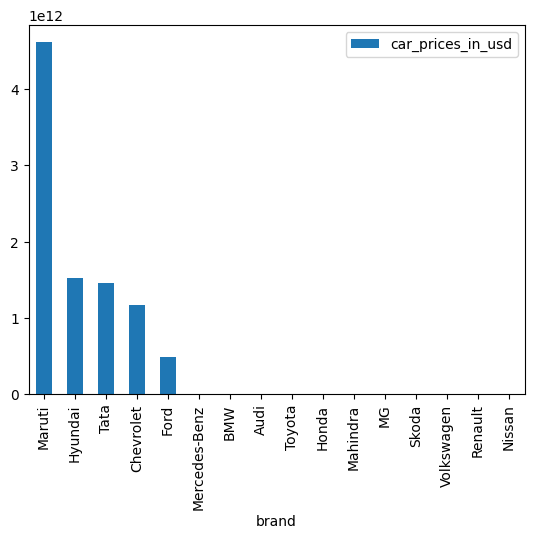

In [223]:
# Visualize the data

(car
.query("tier == 'top'")
.groupby(car["brand"])
.agg({"car_prices_in_usd" : "sum"})
.sort_values("car_prices_in_usd", ascending=False)
).plot.bar()

Now we can see the trend over time

<AxesSubplot: title={'center': 'Oil Price 2013-2017'}, xlabel='Date', ylabel='USD Price'>

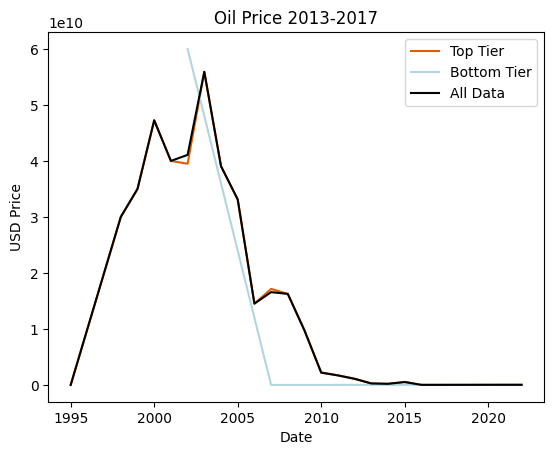

In [224]:
# Line for top tier
(car
  .query("tier == 'top'")
  .groupby(car["manufacture"].dt.year)
  .agg({"car_prices_in_usd": "mean"})
  .loc[:, "car_prices_in_usd"]
  .plot(c="#e25d00",
    legend=True,
    label="Top Tier")
)

# Line for bottom tier
(car
  .query("tier == 'bottom'")
  .groupby(car["manufacture"].dt.year)
  .agg({"car_prices_in_usd": "mean"})
  .loc[:, "car_prices_in_usd"]
  .plot(c="#b1d6e1",
    legend=True,
    label="Bottom Tier")
)

# Line for all data
(car
  .groupby(car["manufacture"].dt.year)
  .agg({"car_prices_in_usd": "mean"})
  .loc[:, "car_prices_in_usd"]
  .plot(title="Oil Price 2013-2017", 
    xlabel="Date", 
    ylabel="USD Price", 
    c="Black",
    legend=True,
    label="All Data")
)


**we can see that in term of mean price, all data and top tier data have same pattern, and bottom tier not really significant to our data. And all data show that we have negative trend**

Of course we can do more analystical based on other columns, but for now we will stop here.

3. Analyze the correlation between the kilometers driven of a car and its price.

To answer this questions we still need to do cleansing especially at kms_driven because the type of data is object.

In [226]:
# Create new column for km values
car['kms_value'] = car['kms_driven'].str.split(" ", 1, expand= True)[0].str.replace(',', '')

# Set the correct number for column
car = car.astype(
    {"kms_value": "int32"
     }
)

/tmp/ipykernel_3914/694322375.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  car['kms_value'] = car['kms_driven'].str.split(" ", 1, expand= True)[0].str.replace(',', '')


Now we ready to analyze.
First let plot our data

<AxesSubplot: xlabel='kms_value', ylabel='car_prices_in_usd'>

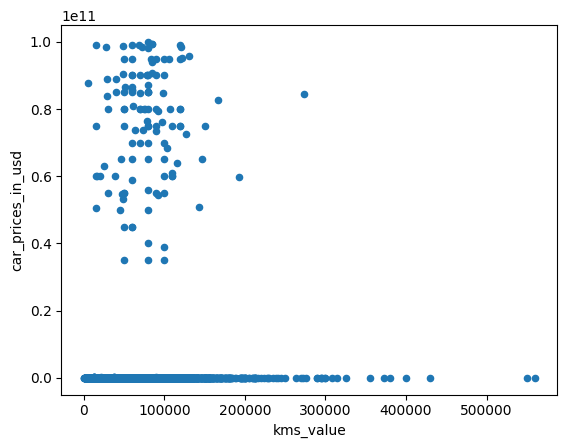

In [227]:
# Plotting data using Scatter plot
car.plot.scatter(x="kms_value", y="car_prices_in_usd")

 But let's find the correlation values

In [228]:
print(f'Our plot show that is weak positive correlation between car prices and km. With the correlation values {scipy.stats.pearsonr(car["car_prices_in_usd"], car["kms_value"])[0].round(3)}')

Our plot show that is weak positive correlation between car prices and km. With the correlation values 0.054


This is happended because several data really have high price.
So we will analysis data and exclude it

In [229]:
# Using describe to see the distribution number
car.describe()

,car_prices_in_usd,kms_value
count,5.512000e+03,5512.000000
mean,1.701122e+09,63211.888062
std,1.147131e+10,41844.131167
min,1.000000e+06,250.000000
25%,3.300000e+06,33151.750000
50%,5.750000e+06,59000.000000
75%,1.137000e+07,84265.250000
max,9.999900e+10,560000.000000


In [23]:
mask = car.describe()[5:6]["car_prices_in_usd"].values[0] #Choose median to filter
car_corr = car.query("car_prices_in_usd < @mask and engine == '1197 cc'") # Filtering data based on criteria
car_corr

,car_name,car_prices_in_usd,kms_driven,fuel_type,transmission,ownership,manufacture,engine,seats,brand,tier,kms_value
15,Hyundai Grand i10 AT Asta,5630000,"59,313 kms",Petrol,Automatic,2nd Owner,2016-01-01,1197 cc,5 Seats,Hyundai,top,59313
20,Maruti Swift Dzire VXI,4340000,"56,568 kms",Petrol,Manual,1st Owner,2014-01-01,1197 cc,5 Seats,Maruti,top,56568
24,Hyundai Grand i10 1.2 Kappa Magna BSIV,5410000,"21,239 kms",Petrol,Manual,1st Owner,2018-01-01,1197 cc,5 Seats,Hyundai,top,21239
32,Hyundai Grand i10 Sportz,4910000,"35,424 kms",Petrol,Manual,1st Owner,2016-01-01,1197 cc,5 Seats,Hyundai,top,35424
79,Hyundai i20 Magna Optional 1.2,4650000,"23,000 kms",Petrol,Manual,1st Owner,2014-01-01,1197 cc,5 Seats,Hyundai,top,23000
...,...,...,...,...,...,...,...,...,...,...,...,...
5359,Hyundai i20 Sportz 1.4 CRDi,3500000,"90,000 kms",Diesel,Manual,1st Owner,2012-01-01,1197 cc,5 Seats,Hyundai,top,90000
5396,Maruti Ciaz ZDi,4500000,"90,000 kms",Diesel,Manual,1st Owner,2014-01-01,1197 cc,5 Seats,Maruti,top,90000
5404,Hyundai Grand i10 Magna,3200000,"40,000 kms",Petrol,Manual,1st Owner,2015-01-01,1197 cc,5 Seats,Hyundai,top,40000
5436,Maruti Alto K10 2010-2014 VXI,2450000,"50,000 kms",Petrol,Manual,1st Owner,2012-01-01,1197 cc,5 Seats,Maruti,top,50000


-0.202

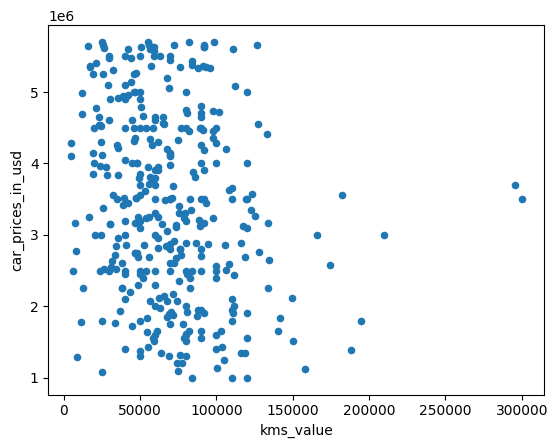

In [230]:
# Plotting
car_corr.plot.scatter(x="kms_value", y="car_prices_in_usd")

scipy.stats.pearsonr(car_corr["car_prices_in_usd"], car_corr["kms_value"])[0].round(3)

After we have done analysis we see there is not big impact, the correlation still weak but now it is positive.

4. Use linear regression to build a model that predicts the price of a car based on the other variables in the dataset.

In [231]:
# set independent and dependent variable
x = car[["fuel_type", "transmission", "ownership", "seats", "brand", "tier", "kms_value"]]
x = pd.get_dummies(data=x, drop_first=True)
y = car['car_prices_in_usd']

In [247]:
# Creating a train and test dataset.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=22)
print(X_train.shape)
print(X_test.shape)

(3307, 48)
(2205, 48)


After splitting the dataset into a test and train we will be importing the Linear Regression model.

In [248]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [249]:
# print the intercept
print(model.intercept_)

-5581630663.309208


In [250]:
# Check the coefficient
coeff_parameter = pd.DataFrame(model.coef_,x.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
kms_value,1.105377e+04
fuel_type_Diesel,1.591531e+09
fuel_type_Electric,1.420853e+09
fuel_type_Lpg,4.917897e+09
fuel_type_Petrol,4.841113e+09
transmission_Manual,1.077192e+09
ownership_1st Owner,-5.341767e+08
ownership_2nd Owner,1.853340e+09
ownership_3rd Owner,3.428529e+09
ownership_4th Owner,1.116011e+10


In [251]:
predictions = model.predict(X_test)
predictions

array([-2.11348435e+09,  1.07281842e+10,  2.83613955e+09, ...,
        8.24058273e+08, -2.08788115e+09,  1.46523495e+09])

<AxesSubplot: xlabel='car_prices_in_usd'>

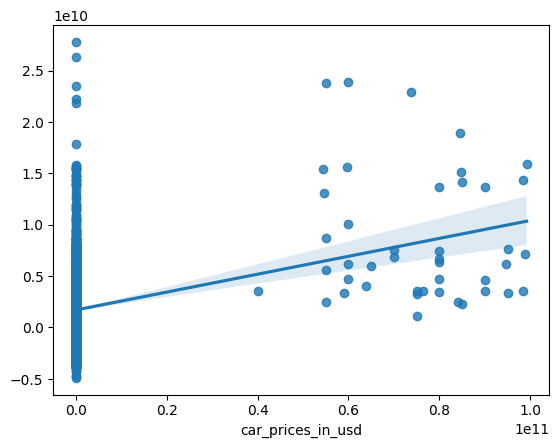

In [252]:
sns.regplot(x = y_test, y = predictions)

In [253]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:      car_prices_in_usd   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     6.556
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.76e-36
Time:                        21:28:00   Log-Likelihood:                -81304.
No. Observations:                3307   AIC:                         1.627e+05
Df Residuals:                    3261   BIC:                         1.630e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.233e+09   9

5. Present the results of your linear regression model, including the coefficients of the variables and any relevant statistical tests. You may also include a plot showing the fitted line and the residuals to visualize the model's fit to the data.

Minus **coefficients** meaning that variable will substract our prediction value, for example if it is 1st owner ship than the predict values will decrease -5.341e+09 and if 2nd the predict values will increase 1.85e+09

Also from data above we get R-squared 0.083, that means this model not realible to predict car prices.

In [254]:
# Check the coefficient
coeff_parameter = pd.DataFrame(model.coef_,x.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
kms_value,1.105377e+04
fuel_type_Diesel,1.591531e+09
fuel_type_Electric,1.420853e+09
fuel_type_Lpg,4.917897e+09
fuel_type_Petrol,4.841113e+09
transmission_Manual,1.077192e+09
ownership_1st Owner,-5.341767e+08
ownership_2nd Owner,1.853340e+09
ownership_3rd Owner,3.428529e+09
ownership_4th Owner,1.116011e+10
